# Computer Vision: Problem Statement 1

Our implementation of a License Plate Extractor is shown below. We will discuss each module in detail in later sections.

<img height='250px' src='cv-ps-landscape.png'/>

## Install and load libraries

In [1]:
# !pip install -r requirements.txt
# !pip install imutils

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

import imutils
from imutils.perspective import four_point_transform
from sklearn.cluster import MeanShift

import editdistance

## Load images + EDA

The image dataset provided already contained cropped images of the license plates from the original image. Hence, it is not required to find the bounding box of the license plate and perform a perspective transform.  

In fact, some images are cropped beyond the corners of the license plates, so an algorithm to detect the four corners of the license plate will need more complex edge cases handling. So, we decided for another approach instead (see below sections).

In [3]:
# Data Paths
base_test_dir = Path('../datasets/cv/PS1')

img_fld = base_test_dir.joinpath('ps1_dataset')
annotation_csv = base_test_dir.joinpath('ps1.csv.csv')

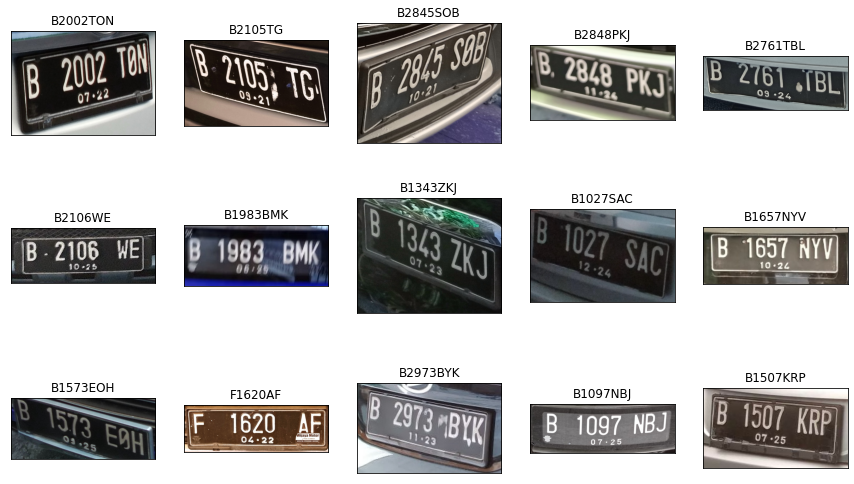

In [4]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        # cv2 Image
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])

annotation_df = pd.read_csv(annotation_csv)
imgs = [img_fld.joinpath(i) for i in annotation_df["IMAGE_FILENAME"]]
show_images(imgs, 3, 5, list(annotation_df['PLATE_NUMBER']), 3)

## Pre-processing: Horizontal image alignment

Automatic image alignment with homography is hard to implement since rectangles may not be detected in the cropped image. As most of the vertical edges are mostly aligned already, we only seek to align the horizontal edges to see whether it helps the model recognize the text better.

Our procedure is detailed below:
- Obtain edge image using Canny edge detection
- Straight line detection using Hough transform
- Filter out 'horizontal' lines with normal angle $\frac{\pi}{3}<\theta<\frac{2\pi}{3}$
- Repeat line detection until good number of 'horizontal' lines
- Use median of thetas as best theta, this will be the dominant axis of the image
- Affine transform or rotate the image such that the dominant axis is horizontal

During the testing phase, we find that affine or rotation helps with the metrics significantly compared with using the original image.

In [5]:
# Some helper functions

def draw_line_on_image(image, lines):
    lined = image.copy()
    for line in lines:
        rho = line[0][0]
        theta = line[0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(lined, pt1, pt2, (0,255,255), 2, cv2.LINE_AA)
    return lined

def filter_horizontal_lines(lines):
    if lines is None: return np.empty((0,1,2), np.float32)
    return lines[np.where((lines[:,0,1]>(np.pi/3)) & (lines[:,0,1]<(np.pi*2/3)))[0]]

Image #130: ../datasets/cv/PS1/ps1_dataset/carro_jIwwmbsE4sduHtt6.jpg
657x451 image, hough_threshold=35.83180799999999, best_theta=1.2566370964050293, m=-0.3249196708202362
coords=[[0, 0], [656, -213], [656, 450], [0, 663]]



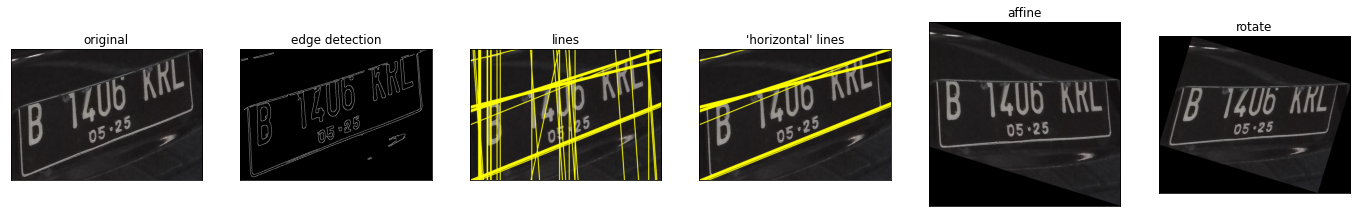

In [6]:
# Load image
image_index = 130
# image_index = annotation_df.sample(n=1).index[0]
image = cv2.imread(str(imgs[image_index]))
print(f'Image #{image_index}: {imgs[image_index]}')

H, W = image.shape[:2]

# Find canny edge image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 50, 150, apertureSize=3)

# Apply Hough transform and filter horizontal lines
hough_threshold = 10
lines = cv2.HoughLines(edged, 0.5, np.pi/45, int(round(hough_threshold, 0)), None, 0, 0)
lines_h = filter_horizontal_lines(lines)

# Initialise variables
lined_1, lined_2, affine, rotate = image, image, image, image
coords = np.zeros((4,2), int)

if lines is not None:
    
    # Keep increasing the threshold until moderate count of horizontal lines
    while len(lines_h) > 20:
        hough_threshold *= 1.2
        lines = cv2.HoughLines(edged, 0.5, np.pi/45, int(round(hough_threshold, 0)), None, 0, 0)
        lines_h = filter_horizontal_lines(lines)
    
    lined_1 = draw_line_on_image(image, lines)
    lined_2 = draw_line_on_image(image, lines_h)
    
     # Select the best theta and calculate gradient
    thetas = lines_h[:,0,1]
    best_theta = np.median(thetas)
    m = - np.cos(best_theta) / np.sin(best_theta)
    
    if len(thetas):
        # Extrapolate the gradient lines from image corners and warp image
        if m > 0: coords = np.array([(0,-m*(W-1)), (W-1,0), (W-1,m*(W-1)+(H-1)), (0,H-1)]).round().astype(int)
        else: coords = np.array([(0,0), (W-1,m*(W-1)), (W-1,H-1), (0,-m*(W-1)+(H-1))]).round().astype(int)
        affine = four_point_transform(image, coords)
        rotate = imutils.rotate_bound(image, int(np.arctan(-m)*180/np.pi))

print(f'{W}x{H} image, hough_threshold={hough_threshold}, best_theta={best_theta}, m={m}')
print(f'coords={coords.tolist()}\n')
images = [image, edged, lined_1, lined_2, affine, rotate]
titles = ['original', 'edge detection', 'lines', '\'horizontal\' lines', 'affine', 'rotate']

_, axes = plt.subplots(1, 6, figsize=(24, 4))
axes = axes.flatten()
for ax, img, title in zip(axes, images, titles):
    if len(img.shape) == 2: ax.imshow(img, cmap='gray')
    else: ax.imshow(img[:,:,::-1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(title)

index=130, diag=544.3408858426859, shape=(451, 657, 3)



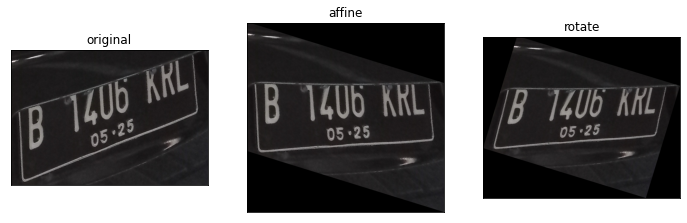

In [7]:
# Preprocessing wrapped as a function

def process_image_transformations(image):

    H, W = image.shape[:2]
    affine, rotate = image, image

    # Find canny edge image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Apply Hough transform and filter horizontal lines
    hough_threshold = 10
    lines = cv2.HoughLines(edged, 0.5, np.pi/45, int(round(hough_threshold, 0)), None, 0, 0)
    lines_h = filter_horizontal_lines(lines)

    if lines is not None:

        # Keep increasing the threshold until moderate count of horizontal lines
        while len(lines_h) > 20:
            hough_threshold *= 1.2
            lines = cv2.HoughLines(edged, 0.5, np.pi/45, int(round(hough_threshold, 0)), None, 0, 0)
            lines_h = filter_horizontal_lines(lines)
            
        # Select the best theta and calculate gradient
        thetas = lines_h[:,0,1]
        best_theta = np.median(thetas)
        m = - np.cos(best_theta) / np.sin(best_theta)
        
        if len(thetas):
            # Extrapolate the gradient lines from image corners and warp image
            if m > 0: coords = np.array([(0,-m*(W-1)), (W-1,0), (W-1,m*(W-1)+(H-1)), (0,H-1)]).round().astype(int)
            else: coords = np.array([(0,0), (W-1,m*(W-1)), (W-1,H-1), (0,-m*(W-1)+(H-1))]).round().astype(int) 
            affine = four_point_transform(image, coords)
            rotate = imutils.rotate_bound(image, int(np.arctan(-m)*180/np.pi))
              
    return affine, rotate

# -------------------------------------------

selected_index = 130 #478
img_original = cv2.imread(str(imgs[selected_index]))
img_affine, img_rotate = process_image_transformations(img_original)
diag = np.sqrt(img_original.shape[0] * img_original.shape[1])
print(f'index={selected_index}, diag={diag}, shape={img_original.shape}\n')

images = [img_original, img_affine, img_rotate]
titles = ['original', 'affine', 'rotate']

_, axes = plt.subplots(1, 3, figsize=(12,4))
axes = axes.flatten()
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img[:,:,::-1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(title)

## Text detection: CRAFT

We use CRAFT for initial text detection and crop out the regions.  
Sorting using the leftmost x-coordinate is also done so that the text will be in the correct order at the end.  

Some license plates also have top to bottom text. To sort it, mean-shift clustering is used, the explanation is in the next section.

In [10]:
import torch

from CRAFT_pytorch import file_utils
from CRAFT_pytorch.craft import CRAFT
from CRAFT_pytorch.test import copyStateDict, test_net
import torch.backends.cudnn as cudnn

craft_model = CRAFT()
gpu_state = torch.cuda.is_available()
print(f'Using GPU: {gpu_state}')

if gpu_state:
    craft_model.load_state_dict(copyStateDict(torch.load('CRAFT_pytorch/ckpts/craft_mlt_25k.pth')))
    craft_model = craft_model.cuda()
    craft_model = torch.nn.DataParallel(craft_model)
    cudnn.benchmark = False
else:
    craft_model.load_state_dict(copyStateDict(torch.load('CRAFT_pytorch/ckpts/craft_mlt_25k.pth', map_location='cpu')))

craft_model.eval()
print(f'CRAFT model loaded!')

Using GPU: True
CRAFT model loaded!


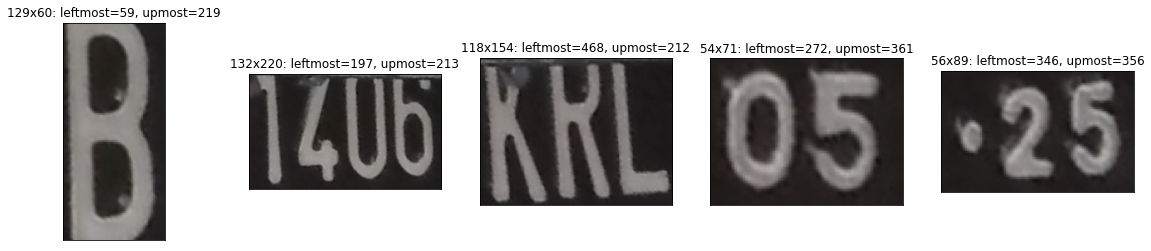

In [11]:
def model_craft(image):
    return test_net(craft_model, image, text_threshold=0.8, link_threshold=0.4, low_text=0.4, cuda=gpu_state, poly=False)[0]

def process_crop_bbox(image, bboxes):
    return [four_point_transform(image, bbox) for bbox in bboxes]

def process_crop_bbox_loose(image, bboxes):
    for i, ((x1,y1),(x2,y2),(x3,y3),(x4,y4)) in enumerate(bboxes):
        bboxes[i] = np.array([[x1-2,y1-2], [x2+2,y2-2], [x3+2,y3+2], [x4-2,y4+2]])
    bboxes[:,:,0] = np.clip(bboxes[:,:,0], 0, image.shape[1]-1)
    bboxes[:,:,1] = np.clip(bboxes[:,:,1], 0, image.shape[0]-1)
    return [four_point_transform(image, bbox) for bbox in bboxes]

def process_bbox_l2r(bboxes):
    return bboxes[np.argsort(bboxes[:,:,0].min(axis=1))]

def process_bbox_l2r_t2b(bboxes, img_diag):
    bboxes_l2r = bboxes[np.argsort(bboxes[:,:,0].min(axis=1))]
    clf = MeanShift(bandwidth=int(img_diag/20)).fit(bboxes_l2r[:,0,1].reshape(-1, 1).astype(int))
    height_indices = np.argsort(clf.cluster_centers_, axis=0)
    reorder_indices = np.concatenate([np.where(clf.labels_ == ind)[0] for ind in height_indices], axis=0)
    return bboxes_l2r[reorder_indices]

# -------------------------------------------

bboxes = model_craft(img_affine)
bboxes = process_bbox_l2r_t2b(bboxes, diag)
img_text_roi = process_crop_bbox_loose(img_affine, bboxes)

_, axes = plt.subplots(1, len(bboxes), figsize=(4*len(bboxes),4))
try: axes = axes.flatten()
except: axes = [axes]
for ax, img, bbox in zip(axes, img_text_roi, bboxes):
    ax.imshow(img[:,:,::-1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(f'{img.shape[0]}x{img.shape[1]}: leftmost={int(bbox[:,0].min())}, upmost={int(bbox[:,1].min())}')

## Pre-processing: Mean-shift Clustering

**Height**  
- We use the height feature as a good indicator to predict whether the text is from the main license plate or elsewhere.  
- Mean-shift clustering is used with the bandwidth proportional to the image size, and the larger height cluster is kept.  
- The advantage is also that no labels are required since it is an unsupervised algorithm.

**Vertical Position**  
- We also used mean-shift clustering to cluster text on the similar vertical level.  
- However, this assumes that the text is horizontally level.  
- Few cases in which our earlier alignment procedure fails resulted in wrong order of the texts.

*Bandwidth Note:*  
Various bandwidths were tested including `min(int(img_diag/10),20)`, `int(img_diag/10)`. We find that `int(img_diag/20)` yields the best result. Image diagonal is calculated using $\sqrt{HW}$ for a $W$-by-$H$ image.

In [12]:
heights = np.array([roi.shape[0] for roi in img_text_roi])
clf = MeanShift(bandwidth=int(diag/20)).fit(heights.reshape(-1, 1))
fil_ind = np.where(clf.labels_ == clf.cluster_centers_.argmax())[0]

print('Bounding box indices with high chance of being the main text:', fil_ind)
print('\nOriginal heights:', heights, '\nFiltered heights:', heights[fil_ind])

Bounding box indices with high chance of being the main text: [0 1 2]

Original heights: [129 132 118  54  56] 
Filtered heights: [129 132 118]


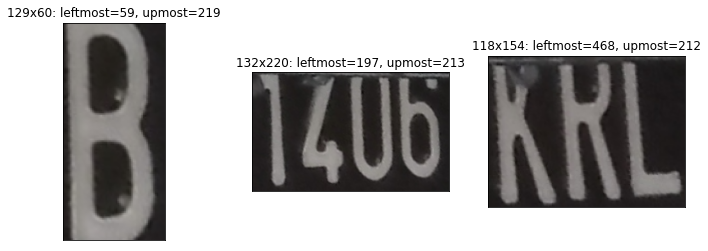

In [13]:
# Filtered letters corresponding to the main text

bboxes_fil = bboxes[fil_ind]
img_text_roi_fil = [img_text_roi[i] for i in fil_ind]

_, axes = plt.subplots(1, len(bboxes_fil), figsize=(4*len(bboxes_fil),4))
try: axes = axes.flatten()
except: axes = [axes]
for ax, img, bbox in zip(axes, img_text_roi_fil, bboxes_fil):
    ax.imshow(img[:,:,::-1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(f'{img.shape[0]}x{img.shape[1]}: leftmost={int(bbox[:,0].min())}, upmost={int(bbox[:,1].min())}')

## Text recognition: Deep Text

We modify the existing script provided, removing the CRAFT model so that DeepText functions as a text recognition engine only, since we are processing the bounding box results from CRAFT. 

In [14]:
from ocr_engine import DeepText

deeptext_ocr = DeepText(lang='english_public')
deeptext_ocr.detect_text(img_text_roi_fil, bboxes_fil, text_only=False)

loading pretrained model from deep_text_recognition_benchmark/saved_models/Public/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth


[{'text': 'B', 'conf': 0.9932},
 {'text': '14Ub', 'conf': 0.3722},
 {'text': 'KKL', 'conf': 0.7105}]

## Post-processing: Ensemble method

This method yields the best text from two prediction results

In [15]:
def process_best_preds(preds1, preds2):
    n1, n2 = len(preds1), len(preds2)
    final_pred = ''
    for i in range(n1):
        dist_mat = np.zeros((n2,), int)
        for j in range(n2): dist_mat[j] = editdistance.eval(preds1[i]['text'], preds2[j]['text'])
        if dist_mat.min() <= 1:
            pred1, pred2 = preds1[i], preds2[dist_mat.argmin()]
            if pred1['conf'] > pred2['conf']: final_pred += pred1['text']
            else: final_pred += pred2['text']
        else:
            final_pred += preds1[i]['text']
    return final_pred
    
process_best_preds([{'text': 'B', 'conf': 0.898}, {'text': '7407', 'conf': 0.598}, {'text': 'JFR', 'conf': 0.7975}],
                   [{'text': '1407', 'conf': 0.6872}, {'text': 'JFR', 'conf': 0.9748}])

'B1407JFR'

# Testing Phase: Altogether

Some fine-tuning was made to the steps earlier, after analysing failure cases.

In [16]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import pickle

import imutils
from imutils.perspective import four_point_transform
from sklearn.cluster import MeanShift

from ocr_engine import DeepText
import easyocr

import torch
from CRAFT_pytorch import file_utils
from CRAFT_pytorch.craft import CRAFT
from CRAFT_pytorch.test import copyStateDict, test_net
import torch.backends.cudnn as cudnn

import editdistance
import re, os

os.makedirs('results', exist_ok=True)

In [17]:
# Data Paths
base_test_dir = Path('../datasets/cv/PS1')

img_fld = base_test_dir.joinpath('ps1_dataset')
annotation_csv = base_test_dir.joinpath('ps1.csv.csv')

annotation_df = pd.read_csv(annotation_csv)
imgs = [img_fld.joinpath(i) for i in annotation_df["IMAGE_FILENAME"]]

In [20]:
class OCR_optimised:
    
    def __init__(self):
        
        self.craft_model = CRAFT()
        self.gpu_state = torch.cuda.is_available()
        print(f'Using GPU: {self.gpu_state}')

        if self.gpu_state:
            self.craft_model.load_state_dict(copyStateDict(torch.load('CRAFT_pytorch/ckpts/craft_mlt_25k.pth')))
            self.craft_model = self.craft_model.cuda()
            self.craft_model = torch.nn.DataParallel(self.craft_model)
            cudnn.benchmark = False
        else:
            self.craft_model.load_state_dict(copyStateDict(torch.load('CRAFT_pytorch/ckpts/craft_mlt_25k.pth', map_location='cpu')))

        self.craft_model.eval()
        self.deeptext_ocr = DeepText(lang='english_public')
        self.reader = easyocr.Reader(['en'])
        
        print(f'CRAFT, DEEP TEXT and EasyOCR models loaded!')
        
    
    def model_craft(self, image):
        return test_net(self.craft_model, image, text_threshold=0.8, link_threshold=0.4, low_text=0.4, cuda=self.gpu_state, poly=False)[0]
    
    def model_deep_text(self, img_text_roi, bboxes):
        return self.deeptext_ocr.detect_text(img_text_roi, bboxes, text_only=False)
    
    def model_reader(self, img_text_roi):
        results = []
        for roi in img_text_roi:
            res = self.reader.readtext(roi)
            if len(res): results.append(res[0][1:])
            else: results.append(('', 0.0))
        return results
    
    
    @staticmethod
    def __filter_horizontal_lines(lines):
        if lines is None: return np.empty((0,1,2), np.float32)
        return lines[np.where((lines[:,0,1]>(np.pi/3)) & (lines[:,0,1]<(np.pi*2/3)))[0]]
    
    def process_image_transformations(self, image):

        H, W = image.shape[:2]
        affine, rotate = image, image

        # Find canny edge image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        edged = cv2.Canny(gray, 50, 150, apertureSize=3)

        # Apply Hough transform and filter horizontal lines
        hough_threshold = 10
        lines = cv2.HoughLines(edged, 0.5, np.pi/45, int(round(hough_threshold, 0)), None, 0, 0)
        lines_h = self.__filter_horizontal_lines(lines)

        if lines is not None:

            # Keep increasing the threshold until moderate count of horizontal lines
            while len(lines_h) > 20:
                hough_threshold *= 1.2
                lines = cv2.HoughLines(edged, 0.5, np.pi/45, int(round(hough_threshold, 0)), None, 0, 0)
                lines_h = self.__filter_horizontal_lines(lines)

            # Select the best theta and calculate gradient
            thetas = lines_h[:,0,1]
            best_theta = np.median(thetas)
            m = - np.cos(best_theta) / np.sin(best_theta)

            if len(thetas):
                # Extrapolate the gradient lines from image corners and warp image
                if m > 0: coords = np.array([(0,-m*(W-1)), (W-1,0), (W-1,m*(W-1)+(H-1)), (0,H-1)]).round().astype(int)
                else: coords = np.array([(0,0), (W-1,m*(W-1)), (W-1,H-1), (0,-m*(W-1)+(H-1))]).round().astype(int) 
                affine = four_point_transform(image, coords)
                rotate = imutils.rotate_bound(image, int(np.arctan(-m)*180/np.pi))

        return affine, rotate
    
    @staticmethod
    def process_filter_large_bbox(bboxes, img_diag):
        heights = (bboxes[:,3,1] - bboxes[:,0,1]).astype(int).reshape(-1, 1)
        clf = MeanShift(bandwidth=int(img_diag/20)).fit(heights)
        fil_ind = np.where(clf.labels_ == clf.cluster_centers_.argmax())[0]
        return bboxes[fil_ind]
    
    @staticmethod
    def process_bbox_l2r_t2b(bboxes, img_diag):
        bboxes_l2r = bboxes[np.argsort(bboxes[:,:,0].min(axis=1))]
        top_left_coords = bboxes_l2r[:,0,1].astype(int).reshape(-1, 1)
        clf = MeanShift(bandwidth=int(img_diag/20)).fit(top_left_coords)
        height_indices = np.argsort(clf.cluster_centers_, axis=0)
        reorder_indices = np.concatenate([np.where(clf.labels_ == ind)[0] for ind in height_indices], axis=0)
        return bboxes_l2r[reorder_indices]
    
    @staticmethod
    def process_crop_bbox(image, bboxes):
        return [four_point_transform(image, bbox) for bbox in bboxes]
    
    @staticmethod
    def process_extract_text_ensemble(preds1, preds2):
        n1, n2 = len(preds1), len(preds2)
        final_pred = ''
        for i in range(n1):
            dist_mat = np.zeros((n2,), int)
            for j in range(n2): dist_mat[j] = editdistance.eval(preds1[i]['text'], preds2[j]['text'])
            if dist_mat.min() <= 1:
                pred1, pred2 = preds1[i], preds2[dist_mat.argmin()]
                if pred1['conf'] > pred2['conf']: final_pred += pred1['text']
                else: final_pred += pred2['text']
            else:
                final_pred += preds1[i]['text']
        return final_pred
    
    @staticmethod
    def process_ensemble_results(deep_text_res, reader_res):
        final_results = []
        for dt, r in zip(deep_text_res, reader_res):
            if dt['conf'] > r[1]: final_results.append(dt)
            else: final_results.append({'text': r[0], 'conf': r[1]})
        return final_results
    
    @staticmethod
    def process_extract_text_basic(preds):
        return ''.join([text['text'] for text in preds])
    
    @staticmethod
    def process_clean_text(text):
        return re.sub('[^A-Z0-9]', '', text.upper())
    
    @staticmethod
    def results_levenshtein_distance(true, pred):
        return (len(true) - editdistance.eval(true,pred)) / len(true)

In [24]:
def get_text_preds_optimised(img_path, ocr, debug=False):
    
    img_original = cv2.imread(img_path)
    img_affine, img_rotate = ocr.process_image_transformations(img_original)
    img_diag = np.sqrt(img_original.shape[0] * img_original.shape[1])
    
    results_all = []
    
    for img in [img_affine, img_rotate]:
        
        bboxes = ocr.model_craft(img)
        bboxes = ocr.process_filter_large_bbox(bboxes, img_diag)
        bboxes = ocr.process_bbox_l2r_t2b(bboxes, img_diag)
        img_text_roi = ocr.process_crop_bbox(img, bboxes)
        deep_text_res = ocr.model_deep_text(img_text_roi, bboxes)
        # reader_res = ocr.model_reader(img_text_roi)
        # results = ocr.process_ensemble_results(deep_text_res, reader_res)
        results_all.append(deep_text_res)
    
    texts = [ocr.process_extract_text_basic(results_all[0]),
             ocr.process_extract_text_basic(results_all[1]),
             ocr.process_extract_text_ensemble(*results_all)]
    
    if debug: return [ocr.process_clean_text(text) for text in texts], results_all
    else: return [ocr.process_clean_text(text) for text in texts]


ocr = OCR_optimised()
all_the_results = []

for img in tqdm(imgs):
    all_the_results.append(get_text_preds_optimised(str(img), ocr))
    
with open('results/all_the_results.pickle', 'wb') as handle:
    pickle.dump(all_the_results, handle)

Using GPU: True
loading pretrained model from deep_text_recognition_benchmark/saved_models/Public/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth


  0%|          | 0/900 [00:00<?, ?it/s]

CRAFT, DEEP TEXT and EasyOCR models loaded!


 50%|████▉     | 448/900 [03:55<03:12,  2.35it/s]/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
 94%|█████████▍| 847/900 [06:30<00:17,  2.95it/s]/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 900/900 [06:48<00:00,  2.20it/s]


## Results

Ensembling technique is used with both DeepText and EasyOCR for the best results.

Using ensembling, the results were as below:
- Affine   : 0.9422
- Rotate   : 0.9335
- Ensemble : 0.9404

which is lower than DeepText only. This is because EasyOCR returns predictions with very high confidences.  
We continue to use DeepText only instead.

In [25]:
with open('results/all_the_results.pickle', 'rb') as handle:
    all_the_results = pickle.load(handle)

# Manually correct some mislabelled entries
annotation_df['PLATE_NUMBER'].iloc[[739,876]] = ['SLL1240L', 'GBJ2202U']

annotation_df['preds_affine'] = [res[0] for res in all_the_results]
annotation_df['ldist_affine'] = annotation_df.apply(lambda x: ocr.results_levenshtein_distance(x.PLATE_NUMBER, x.preds_affine), axis=1)

annotation_df['preds_rotate'] = [res[1] for res in all_the_results]
annotation_df['ldist_rotate'] = annotation_df.apply(lambda x: ocr.results_levenshtein_distance(x.PLATE_NUMBER, x.preds_rotate), axis=1)

annotation_df['preds_combine'] = [res[2] for res in all_the_results]
annotation_df['ldist_combine'] = annotation_df.apply(lambda x: ocr.results_levenshtein_distance(x.PLATE_NUMBER, x.preds_combine), axis=1)

print('Mean Levenshtein distance')
print(f'Affine   : {round(annotation_df.ldist_affine.mean(), 4)}')
print(f'Rotate   : {round(annotation_df.ldist_rotate.mean(), 4)}')
print(f'Ensemble : {round(annotation_df.ldist_combine.mean(), 4)}')
print('')

annotation_df

Mean Levenshtein distance
Affine   : 0.9518
Rotate   : 0.9433
Ensemble : 0.9511



/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,IMAGE_FILENAME,PLATE_NUMBER,preds_affine,ldist_affine,preds_rotate,ldist_rotate,preds_combine,ldist_combine
0,carro_j02d7wxqAvjIjFsG.jpg,B2002TON,B2002TON,1.000000,B2002TON,1.000000,B2002TON,1.000000
1,carro_PyLHOekBSD2grTKb.jpg,B2105TG,B2105G,0.857143,2705IG,0.571429,B2105G,0.857143
2,carro_7KQ9AM21pfUS7lN6.jpg,B2845SOB,B2845SOB,1.000000,32845SOB,0.875000,B2845SOB,1.000000
3,carro_xsmCftZ1Ho5C3948.jpg,B2848PKJ,B2848PKJ,1.000000,B2848PKJ,1.000000,B2848PKJ,1.000000
4,carro_KgjxxEKXNwvRdKif.jpg,B2761TBL,B2761TTL,0.875000,B2761TBL,1.000000,B2761TBL,1.000000
...,...,...,...,...,...,...,...,...
895,17594160.jpg,SJU8813P,SJU8813P,1.000000,SJU8813P,1.000000,SJU8813P,1.000000
896,17559976.jpg,SKA9865B,SKA9865B,1.000000,SKA9865B,1.000000,SKA9865B,1.000000
897,17588077.jpg,SGV1026X,SGV1026X,1.000000,SGV1026X,1.000000,SGV1026X,1.000000
898,17584375.jpg,SGB2542X,SGB2542X,1.000000,SGB2542X,1.000000,SGB2542X,1.000000


In [26]:
# Bad failure cases
annotation_df[annotation_df['ldist_affine']<0.6]

,IMAGE_FILENAME,PLATE_NUMBER,preds_affine,ldist_affine,preds_rotate,ldist_rotate,preds_combine,ldist_combine
24,IMG_20210215_124928.jpg,B1123ELQ,ELQ,0.375000,ELQ,0.375000,ELQ,0.375000
92,carro_V80MLpMI9ME8a2MZ.jpg,F1461ID,ID1461,0.428571,ID1461,0.428571,ID1461,0.428571
114,carro_5Nho4VCz9IQbKbNX.jpg,B1315HU,HU13315,0.285714,THUIB13315,0.000000,THU13315,0.142857
138,carro_iwj33rTd0j7UKBx9.jpg,B1720KFW,3TZUPKN,0.125000,317Z0PWW,0.500000,3TZUPKN,0.125000
152,carro_qsMmAPQtvHZUmfDz.jpg,B1855WYC,WYC1855B,0.250000,WYCB1855,0.250000,WYC1855B,0.250000
157,carro_1rCyy574SM2gDiXP.jpg,B2795RT,2795,0.571429,2795RT,0.857143,2795,0.571429
205,carro_eBDnwrZfvThTbpQo.jpg,B444DHE,BALLDHE,0.571429,444OHE,0.714286,BALLDHE,0.571429
252,carro_xxs4wkVa5U5V0yuf.jpg,B2758SOZ,SOZB2758,0.250000,SOZB2758,0.250000,SOZB2758,0.250000
296,carro_fqYlHWNStukeGsOZ.jpg,T1698ZT,1698ZII,0.571429,698,0.428571,1698ZII,0.571429
320,carro_3HEftBVNarU0xXFI.jpg,TBP6076,6076TBP,0.142857,TBP6076,1.000000,6076TBP,0.142857


**Individual testing to visualise failure cases**

(['346BL', '346BL', '346BL'], [[{'text': '346BL', 'conf': 0.367}], [{'text': '346BL', 'conf': 0.1592}]])
../datasets/cv/PS1/ps1_dataset/17558764.jpg


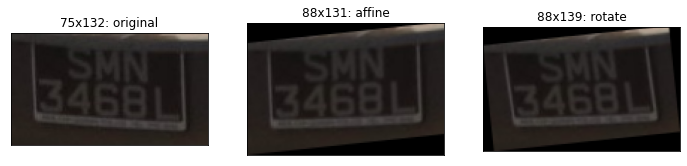

In [27]:
ind = 873
results = get_text_preds_optimised(str(imgs[ind]), ocr, debug=True)
print(results)
print(str(imgs[ind]))

img_original = cv2.imread(str(imgs[ind]))
img_affine, img_rotate = ocr.process_image_transformations(img_original)
img_diag = np.sqrt(img_original.shape[0] * img_original.shape[1])

images = [img_original, img_affine, img_rotate]
titles = ['original', 'affine', 'rotate']

_, axes = plt.subplots(1, 3, figsize=(12,4))
axes = axes.flatten()
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img[:,:,::-1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(f'{img.shape[0]}x{img.shape[1]}: {title}')

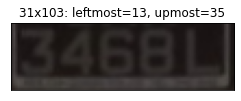

In [28]:
bboxes = ocr.model_craft(img_affine)
bboxes = ocr.process_filter_large_bbox(bboxes, img_diag)
bboxes = ocr.process_bbox_l2r_t2b(bboxes, img_diag)
img_text_roi = ocr.process_crop_bbox(img_affine, bboxes)

_, axes = plt.subplots(1, len(bboxes), figsize=(4*len(bboxes),4))
try: axes = axes.flatten()
except: axes = [axes]
for ax, img, bbox in zip(axes, img_text_roi, bboxes):
    ax.imshow(img[:,:,::-1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(f'{img.shape[0]}x{img.shape[1]}: leftmost={int(bbox[:,0].min())}, upmost={int(bbox[:,1].min())}')

## Final

Affine gives us the best *Levenshtein distance* score, so we use this as our final predictions

In [29]:
final_df = annotation_df[['IMAGE_FILENAME', 'PLATE_NUMBER']].copy()

# Manually correct some mislabelled entries
final_df['PLATE_NUMBER'].iloc[[739,876]] = ['SLL1240L', 'GBJ2202U']
final_df['predictions'] = [res[0] for res in all_the_results]
final_df['levenshtein distance'] = final_df.apply(lambda x: ocr.results_levenshtein_distance(x.PLATE_NUMBER, x.predictions), axis=1)
final_df.to_csv('results/output_cv_ps1.csv', index=False)

final_df

,IMAGE_FILENAME,PLATE_NUMBER,predictions,levenshtein distance
0,carro_j02d7wxqAvjIjFsG.jpg,B2002TON,B2002TON,1.000000
1,carro_PyLHOekBSD2grTKb.jpg,B2105TG,B2105G,0.857143
2,carro_7KQ9AM21pfUS7lN6.jpg,B2845SOB,B2845SOB,1.000000
3,carro_xsmCftZ1Ho5C3948.jpg,B2848PKJ,B2848PKJ,1.000000
4,carro_KgjxxEKXNwvRdKif.jpg,B2761TBL,B2761TTL,0.875000
...,...,...,...,...
895,17594160.jpg,SJU8813P,SJU8813P,1.000000
896,17559976.jpg,SKA9865B,SKA9865B,1.000000
897,17588077.jpg,SGV1026X,SGV1026X,1.000000
898,17584375.jpg,SGB2542X,SGB2542X,1.000000


In [30]:
annotation_df.to_csv('results/output_cv_ps1_full.csv', index=False)